In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download the Dataset

In [ ]:
# install kaggle
!pip install -q kaggle

In [ ]:
# create kaggle folder
!mkdir ~/.kaggle

# copy the kaggle.json to the folder created
!cp /content/drive/MyDrive/Colab_Notebooks/Kaggle_API_Token/kaggle.json ~/.kaggle/

# permission for the jason to act
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Loading the dataset using Kaggle API Command
!kaggle datasets download -d humansintheloop/semantic-segmentation-of-aerial-imagery

 57% 17.0M/29.6M [00:00<00:00, 54.0MB/s]
100% 29.6M/29.6M [00:00<00:00, 78.7MB/s]


In [ ]:
# Unzipping the dataset
!unzip /content/semantic-segmentation-of-aerial-imagery.zip

# Prepare the Data

In [ ]:
import os
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
plt.style.use('fivethirtyeight')

#### Reading the paths of the images and their masks

In [ ]:
DATA_SOURCE_PATH = '/content/Semantic segmentation dataset'
tiles = sorted(os.listdir(DATA_SOURCE_PATH))[:-1]


raw_images_dataset = []
for tile in tiles:
    fil_pre_path = os.path.join(DATA_SOURCE_PATH, tile, 'images')
    for fil in sorted(os.listdir(fil_pre_path)):
        fil_path = os.path.join(fil_pre_path, fil)
        fil = cv2.imread(fil_path)
        fil = cv2.cvtColor(fil, cv2.COLOR_BGR2RGB)
        raw_images_dataset.append(fil)


raw_masks_dataset = []
for tile in tiles:
    fil_pre_path = os.path.join(DATA_SOURCE_PATH, tile, 'masks')
    for fil in sorted(os.listdir(fil_pre_path)):
        fil_path = os.path.join(fil_pre_path, fil)
        fil = cv2.imread(fil_path)
        fil = cv2.cvtColor(fil, cv2.COLOR_BGR2RGB)
        raw_masks_dataset.append(fil)

#### Display a sample image and its mask

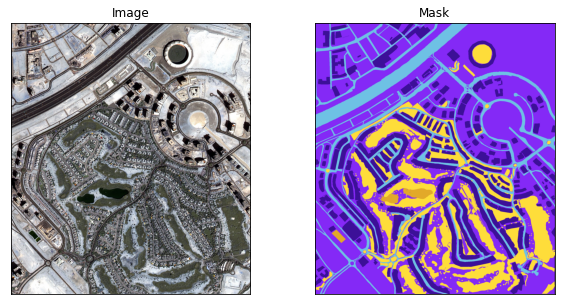

In [ ]:
sample_id = np.random.randint(0, len(raw_images_dataset), size = 1)[0]

plt.figure(figsize = (10,5))

plt.subplot(121)
plt.imshow(raw_images_dataset[sample_id])
plt.title('Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(raw_masks_dataset[sample_id])
plt.title('Mask')
plt.xticks([])
plt.yticks([])

plt.show()

#### Divide the images into patches

Since the images are pretty large in size, we will divide them into 256 X 256 smaller patches. We will also divide the masks into 256 X 256 patches.

We'll use the `patchify` library to divide the images into smaller patches.

In [ ]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from patchify import patchify

PATCH_SIZE = 256


images_dataset = []
for img in raw_images_dataset:
    cropped_height = int((img.shape[0]//PATCH_SIZE)*PATCH_SIZE)
    cropped_width = int((img.shape[1]//PATCH_SIZE)*PATCH_SIZE)
    cropped_image = img[:cropped_height, :cropped_width]
    patches = patchify(cropped_image, (PATCH_SIZE, PATCH_SIZE, 3), step = PATCH_SIZE)
    patches = np.squeeze(patches, axis = 2)
    patches = patches.reshape(patches.shape[0]*patches.shape[1], patches.shape[2], patches.shape[3], patches.shape[4])
    for patch in patches:
        images_dataset.append(patch)

images_dataset = np.array(images_dataset)


masks_dataset = []
for mask in raw_masks_dataset:
    cropped_height = int((mask.shape[0]//PATCH_SIZE)*PATCH_SIZE)
    cropped_width = int((mask.shape[1]//PATCH_SIZE)*PATCH_SIZE)
    cropped_mask = mask[:cropped_height, :cropped_width]
    patches = patchify(cropped_mask, (PATCH_SIZE, PATCH_SIZE, 3), step = PATCH_SIZE)
    patches = np.squeeze(patches, axis = 2)
    patches = patches.reshape(patches.shape[0]*patches.shape[1], patches.shape[2], patches.shape[3], patches.shape[4])
    for patch in patches:
        masks_dataset.append(patch)

masks_dataset = np.array(masks_dataset)

#### Display a patch of an image and its corresponding mask

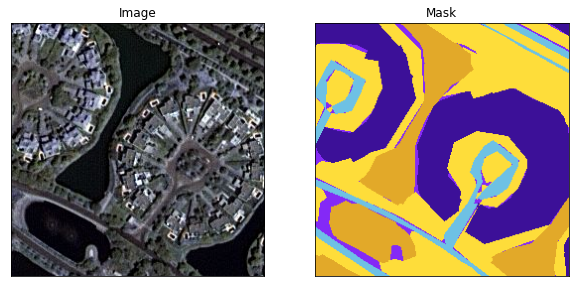

In [ ]:
sample_id = np.random.randint(0, len(images_dataset), size = 1)[0]

plt.figure(figsize = (10,5))

plt.subplot(121)
plt.imshow(images_dataset[sample_id])
plt.title('Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(masks_dataset[sample_id])
plt.title('Mask')
plt.xticks([])
plt.yticks([])

plt.show()

#### Convert the hex color codes to RGB color codes

In [ ]:
hex_color_codes = {'Building': '#3C1098',
                    'Land': '#8429F6',
                    'Road': '#6EC1E4',
                    'Vegetation': '#FEDD3A',
                    'Water': '#E2A929',
                    'Unlabeled': '#9B9B9B'}

In [ ]:
rgb_colors = [tuple(int(hex[1:][i:i+2], 16) for i in (0, 2, 4)) for hex in hex_color_codes.values()]
rgb_colors

[(60, 16, 152),
 (132, 41, 246),
 (110, 193, 228),
 (254, 221, 58),
 (226, 169, 41),
 (155, 155, 155)]

In [ ]:
rgb_color_codes = {label: color for label, color in zip(list(hex_color_codes.keys()), rgb_colors)}
rgb_color_codes

{'Building': (60, 16, 152),
 'Land': (132, 41, 246),
 'Road': (110, 193, 228),
 'Unlabeled': (155, 155, 155),
 'Vegetation': (254, 221, 58),
 'Water': (226, 169, 41)}

#### Encode the RGB colors of each pixel in the masks to integer labels

In [ ]:
category_codes = {'Building': 0,
                    'Land': 1,
                    'Road': 2,
                    'Unlabeled': 3,
                    'Vegetation': 4,
                    'Water': 5}

In [ ]:
def RGB_to_2d_color_label(mask):

    label_mask = np.zeros(mask.shape, dtype = np.uint8)
    
    label_mask[np.all(mask == np.array(rgb_color_codes['Building']), axis = -1)] = category_codes['Building']
    label_mask[np.all(mask == np.array(rgb_color_codes['Land']), axis = -1)] = category_codes['Land']
    label_mask[np.all(mask == np.array(rgb_color_codes['Road']), axis = -1)] = category_codes['Road']
    label_mask[np.all(mask == np.array(rgb_color_codes['Unlabeled']), axis = -1)] = category_codes['Unlabeled']
    label_mask[np.all(mask == np.array(rgb_color_codes['Vegetation']), axis = -1)] = category_codes['Vegetation']
    label_mask[np.all(mask == np.array(rgb_color_codes['Water']), axis = -1)] = category_codes['Water']

    label_mask = label_mask[:,:,0]

    return label_mask

In [ ]:
labeled_masks = [RGB_to_2d_color_label(mask) for mask in masks_dataset]
labeled_masks = np.array(labeled_masks)

In [ ]:
print('Shape of labeled mask dataset: ', labeled_masks.shape)

Shape of labeled mask dataset:  (1305, 256, 256)


#### Display a patch of an image, its corresponding mask and its integer labeled mask

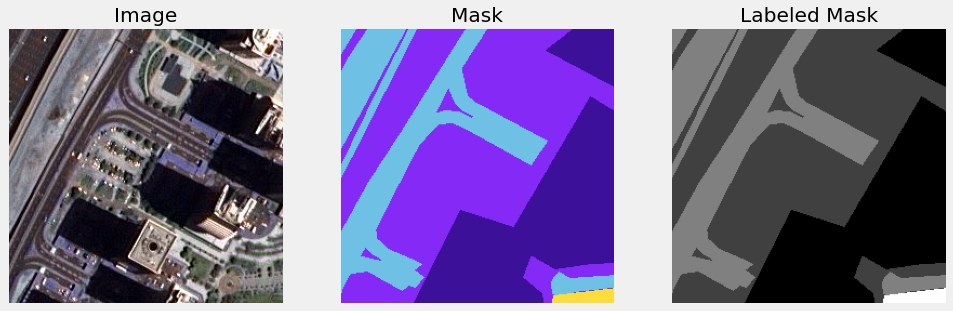

In [ ]:
import matplotlib.pyplot as plt

sample_id = np.random.randint(0, images_dataset.shape[0])
sample_image = images_dataset[sample_id]
sample_mask = masks_dataset[sample_id]
labeled_mask = labeled_masks[sample_id]

plt.figure(figsize = (15, 5))

plt.subplot(131)
plt.imshow(sample_image)
plt.title('Image')
plt.xticks([])
plt.yticks([])

plt.subplot(132)
plt.imshow(sample_mask)
plt.title('Mask')
plt.xticks([])
plt.yticks([])

plt.subplot(133)
plt.imshow(labeled_mask, cmap = 'gray')
plt.title('Labeled Mask')
plt.xticks([])
plt.yticks([])

plt.show()

#### Convert the integer labels to one-hot encoded labels

In [ ]:
import tensorflow as tf
from tensorflow import keras

labeled_masks_categorical = keras.utils.to_categorical(labeled_masks)

In [ ]:
print('Shape of one-hot encoded labeled masks dataset: ', labeled_masks_categorical.shape)

Shape of one-hot encoded labeled masks dataset:  (1305, 256, 256, 6)


#### Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images_dataset, labeled_masks_categorical, test_size = 0.2, random_state = 42)

In [ ]:
print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (1044, 256, 256, 3)
y train shape:  (1044, 256, 256, 6)
X test shape:  (261, 256, 256, 3)
y test shape:  (261, 256, 256, 6)


# Define the Model

#### We'll use the `segmentation-models` library to use different loss functions and performance metrics

In [ ]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.3 MB/s 


#### Define UNet Architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, MaxPooling2D, Dropout, Lambda, concatenate
from tensorflow.keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def build_UNet_model(N_CLASSES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x/255)(inputs)

    # Contraction path
    # Block 1
    c1 = Conv2D(8, (3,3), activation='relu', kernel_initializer='he_normal', padding = 'same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(8, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)

    # Block 2
    c2 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)

    # Block 3
    c3 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2,2))(c3)

    # Block 4
    c4 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2,2))(c4)

    # Block 5
    c5 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    p5 = MaxPooling2D((2,2))(c5)

    # Block 6
    c6 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
    c6 = Dropout(0.3)(c6)
    c6 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)


    # Expansion path
    # Block 7
    u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c5])
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.3)(c7)
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    # Block 8
    u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c4])
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    # Block 9
    u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c3])
    c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # Block 10
    u10 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c9)
    u10 = concatenate([u10, c2])
    c10 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
    c10 = Dropout(0.1)(c10)
    c10 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

    # Block 11
    u11 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c10)
    u11 = concatenate([u11, c1])
    c11 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
    c11 = Dropout(0.1)(c11)
    c11 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)

    outputs = Conv2D(N_CLASSES, (1, 1), activation='softmax')(c11)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    
    # model.compile(optimizer='adam', loss = [jacard_coef_loss], metrics = [jacard_coef])

    return model

#### Find the class weights of the categories present in the masks

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight = 'balanced', classes =  np.unique(np.ravel(labeled_masks)), y = np.ravel(labeled_masks))

print('class weights are: ', weights)

class weights are:  [ 1.21840647  0.31278179  1.78506885 34.95017654  1.63018853  1.28221878]


#### Define the loss function and the performance metrics

In [ ]:
import segmentation_models as sm

dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

iou_metric = sm.metrics.IOUScore()
metrics=['accuracy', jacard_coef, iou_metric]

#### Initialize UNet Model

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
N_CLASSES = 6

In [ ]:
model = build_UNet_model(N_CLASSES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model.compile(optimizer = 'Adam', loss = total_loss, metrics = metrics)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 256, 256, 8)  224         ['lambda_1[0][0]']               
                                                                                                  
 dropout_11 (Dropout)           (None, 256, 256, 8)  0           ['conv2d_23[0][0]']        

#### Define callbacks
We'll use the `EarlyStopping` callback to prevent overfitting and the `ModelCheckpoint` callback to save the best model

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, verbose = 1),
             keras.callbacks.ModelCheckpoint(filepath = '/content/arial_imagery_model.h5', monitor = 'val_loss', verbose = 1, save_best_only = True)]

# Model Training

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size = 8,
                    verbose=1,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks = callbacks)

Epoch 1/100
131/131 [==============================] - ETA: 0s - loss: 0.7395 - accuracy: 0.5310 - jacard_coef: 0.2909 - iou_score: 0.1787
Epoch 1: val_loss improved from inf to 0.65516, saving model to /content/arial_imagery_model.h5
131/131 [==============================] - 28s 90ms/step - loss: 0.7395 - accuracy: 0.5310 - jacard_coef: 0.2909 - iou_score: 0.1787 - val_loss: 0.6552 - val_accuracy: 0.7189 - val_jacard_coef: 0.4808 - val_iou_score: 0.2694
Epoch 2/100
130/131 [============================>.] - ETA: 0s - loss: 0.5945 - accuracy: 0.6677 - jacard_coef: 0.4441 - iou_score: 0.2894
Epoch 2: val_loss improved from 0.65516 to 0.50373, saving model to /content/arial_imagery_model.h5
131/131 [==============================] - 9s 70ms/step - loss: 0.5942 - accuracy: 0.6675 - jacard_coef: 0.4437 - iou_score: 0.2896 - val_loss: 0.5037 - val_accuracy: 0.7335 - val_jacard_coef: 0.5257 - val_iou_score: 0.3322
Epoch 3/100
130/131 [============================>.] - ETA: 0s - loss: 0.5038

# Model Performance

#### Plot the loss value through the epochs

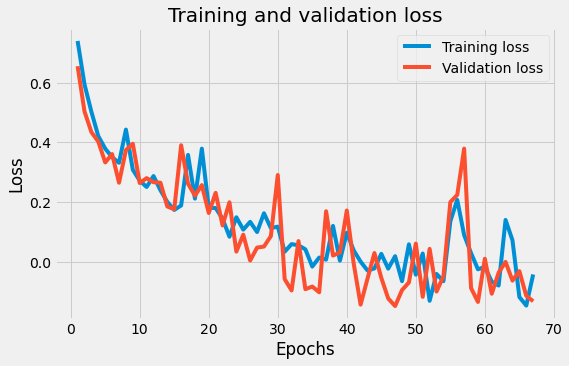

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize = (8,5))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Plot the accuracy through the epochs

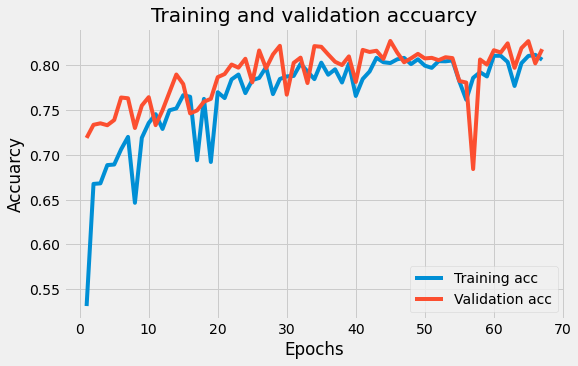

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

plt.figure(figsize = (8,5))
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuarcy')
plt.legend()
plt.show()

#### Plot the IOU Score through the epochs

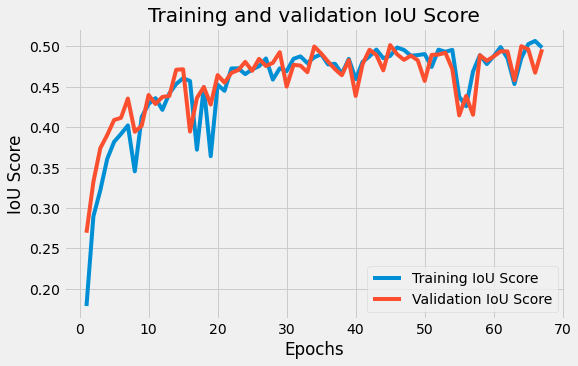

In [ ]:
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.figure(figsize = (8,5))
plt.plot(epochs, acc, label='Training IoU Score')
plt.plot(epochs, val_acc, label='Validation IoU Score')
plt.title('Training and validation IoU Score')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.legend()
plt.show()

# Prediction on the test data

In [ ]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

#### Mean IOU Score

In [ ]:
n_classes = 6
IOU_keras = keras.metrics.MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.5432928


#### Display a patch of an image, its actual mask and its predicted mask

In [ ]:
y_test_argmax=np.argmax(y_test, axis=3)

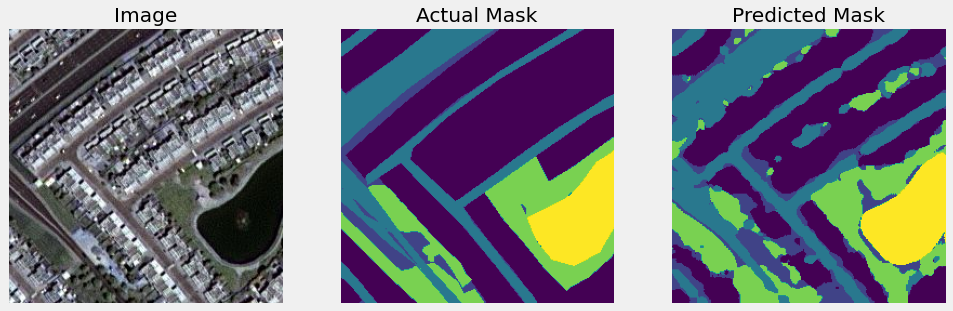

In [ ]:
sample_id = np.random.randint(0, X_test.shape[0])
sample_image = X_test[sample_id]
sample_mask = y_test_argmax[sample_id]
sample_image_input = np.expand_dims(sample_image, axis = 0)
prediction = model.predict(sample_image_input)
prediction = np.squeeze(prediction)
predicted_mask = np.argmax(prediction, axis = 2)

plt.figure(figsize = (15, 5))

plt.subplot(131)
plt.imshow(sample_image)
plt.title('Image')
plt.xticks([])
plt.yticks([])

plt.subplot(132)
plt.imshow(sample_mask)
plt.title('Actual Mask')
plt.xticks([])
plt.yticks([])

plt.subplot(133)
plt.imshow(predicted_mask)
plt.title('Predicted Mask')
plt.xticks([])
plt.yticks([])

plt.show()

# Save the Model

In [ ]:
import shutil

model_source_path = '/content/arial_imagery_model.h5'
model_destination_path = '/content/drive/MyDrive/Colab_Notebooks/Object_Segmentation/U_Net/Unet_Arial_Imagery/arial_imagery_model.h5'

shutil.copyfile(model_source_path, model_destination_path)

'/content/drive/MyDrive/Colab_Notebooks/Object_Segmentation/U_Net/Unet_Arial_Imagery/arial_imagery_model.h5'